In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle
import seaborn as sns
from pandas import Timestamp
import gpflow
from gpflow.utilities import print_summary
from gpflow import set_trainable
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import timedelta
from gpflow.config import default_float
import math

In [2]:
def read_file(path):
    d = pickle.load(open(path, 'rb'))
    X = d['X']
    Y = d['Y']
    
    Y[Y==0] = np.nan
    keep = ~np.isnan(Y[:,0])
    Y = Y[keep,:]
    X = X[keep,:]
    
    return X, Y

In [3]:
f = lambda time: Timestamp.fromtimestamp(time*3600)
f2 = np.vectorize(f)

In [4]:
X, Y = read_file('kampala_23_09_20.p')

In [5]:
X[0]

array([3.2610756e+01, 3.6020900e-01, 4.4451800e+05])

In [6]:
X.shape, Y.shape

((4896, 3), (4896, 1))

In [7]:
np.isnan(np.sum(X))

False

In [8]:
longs = [X[:,0][index] for index in sorted(np.unique(X[:,0], return_index=True)[1])]
lats = [X[:,1][index] for index in sorted(np.unique(X[:,1], return_index=True)[1])]

In [9]:
def cross_validation(X, Y, long, lat):
    
    location_indices = np.where(np.logical_and(X[:,0]==long, X[:,1]==lat))
    
    Xset = X[np.logical_not(np.logical_and(X[:,0]==long, X[:,1]==lat))]
    Yset = np.delete(Y, slice(location_indices[0][0],location_indices[0][-1]+1), axis=0)
        
    Xtraining = Xset[::2,:]
    Ytraining = Yset[::2,:]
    
    Xtest = X[np.logical_and(X[:,0]==long, X[:,1]==lat)]
    Ytest = Y[location_indices[0][0]:location_indices[0][-1]+1]
    
    k = gpflow.kernels.RBF(lengthscales=[0.08, 0.08, 1.], variance=625) + gpflow.kernels.Bias()
    
    m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=k, mean_function=None)
    m.likelihood.variance.assign(400)
    
    
    opt = gpflow.optimizers.Scipy()
        
    def objective_closure():
        return - m.log_marginal_likelihood()
    
    opt_logs = opt.minimize(objective_closure,
                            m.trainable_variables,
                            options=dict(maxiter=100))
    mean, var = m.predict_f(Xtest)
        
    rmse = sqrt(mean_squared_error(Ytest, mean.numpy()))
    
    return mean.numpy(), var.numpy(), Xtest, Ytest, rmse

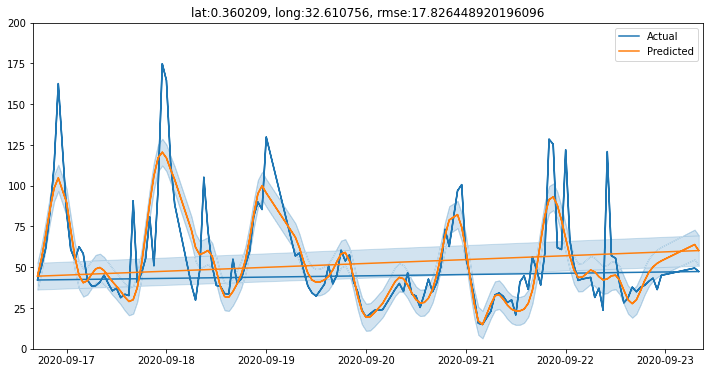

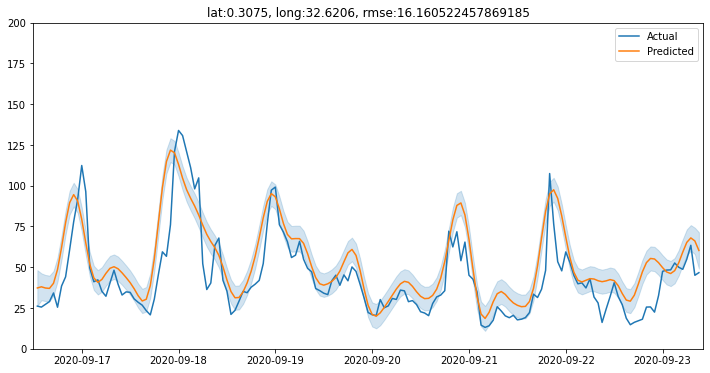

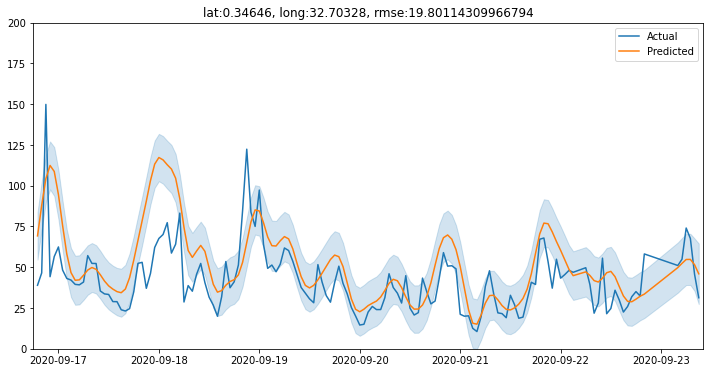

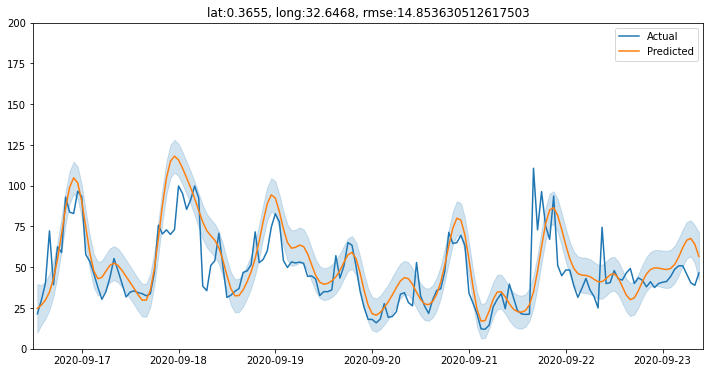

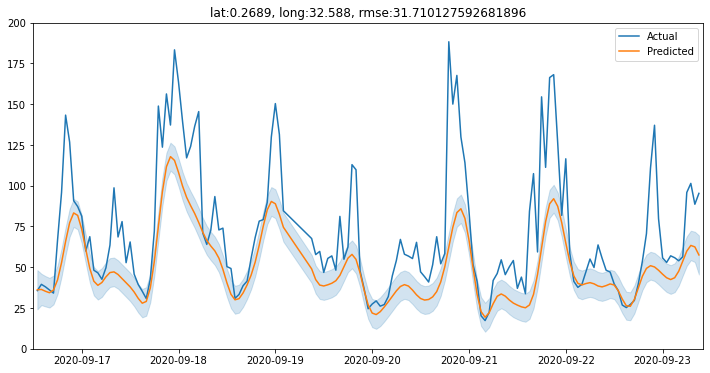

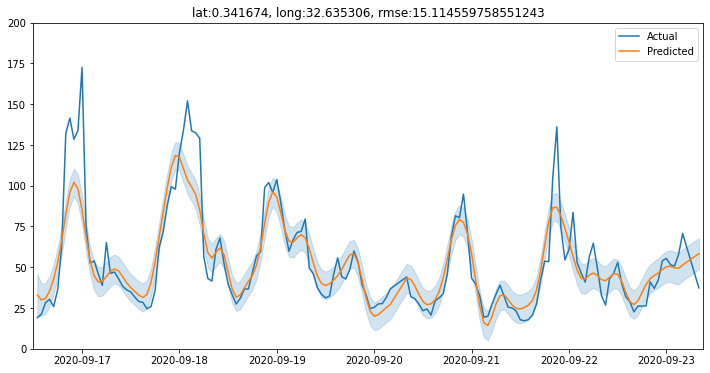

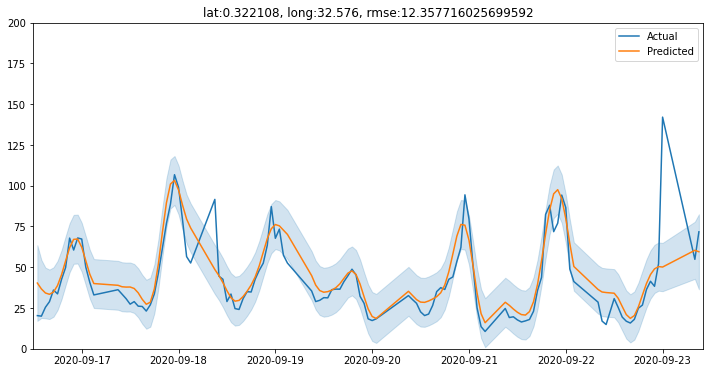

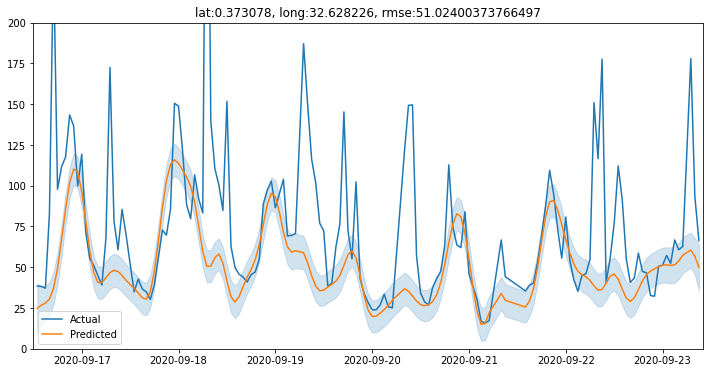

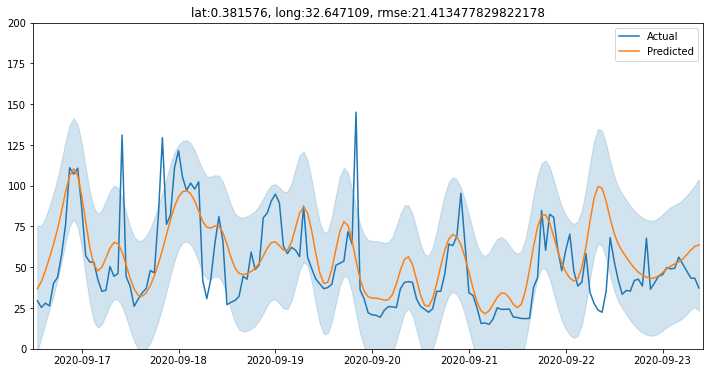

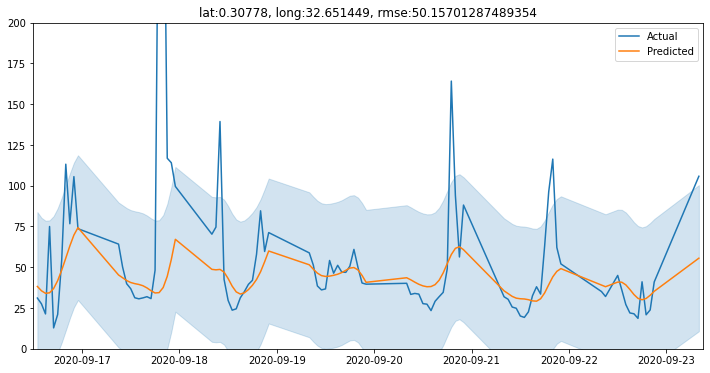

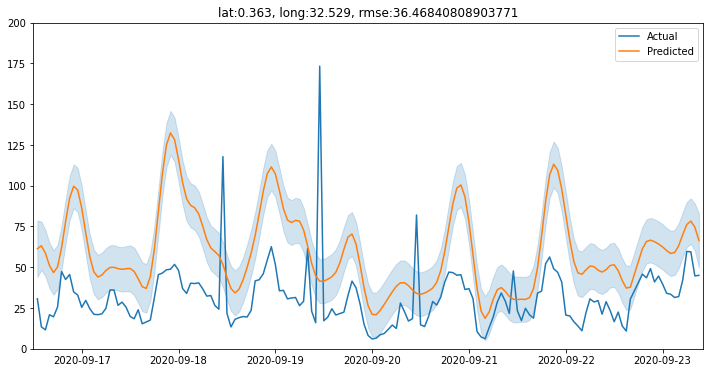

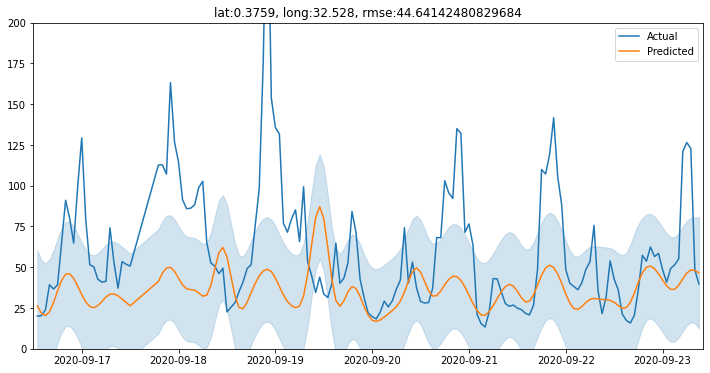

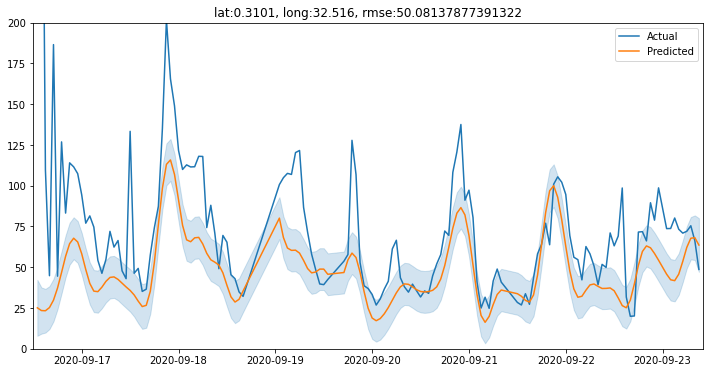

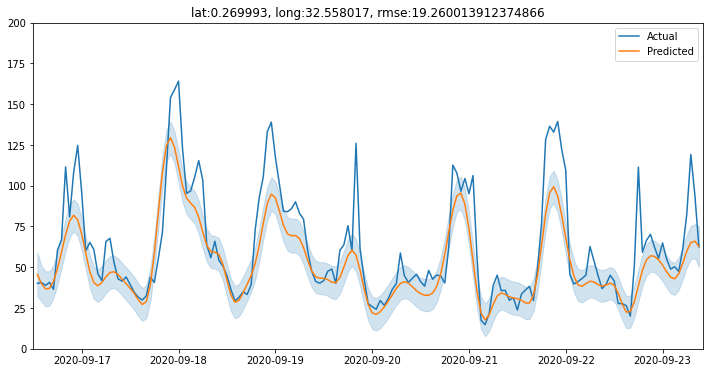

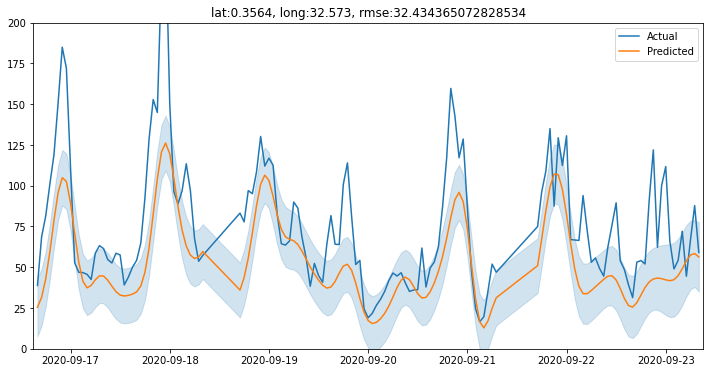

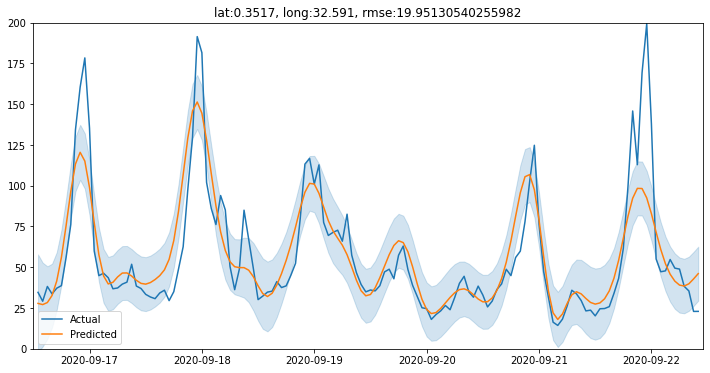

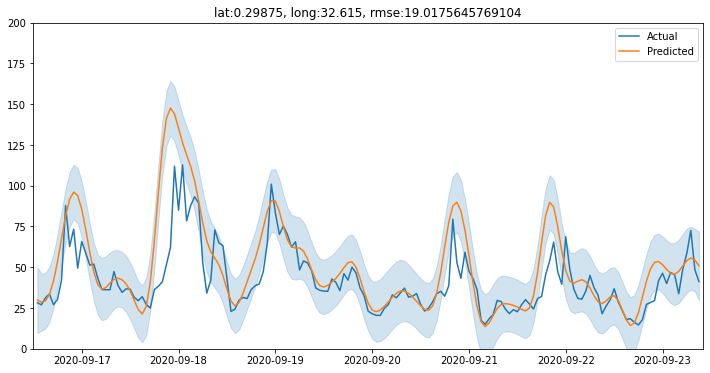

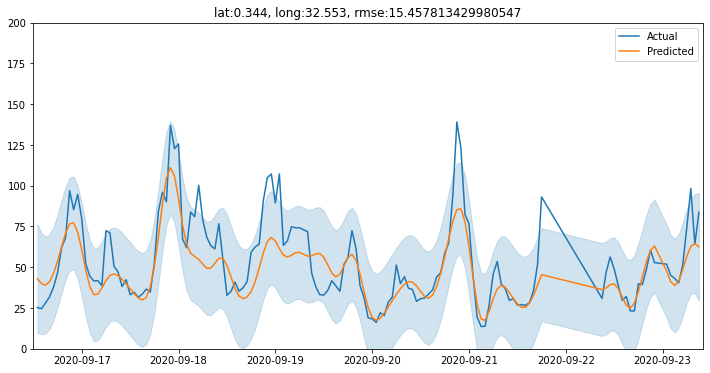

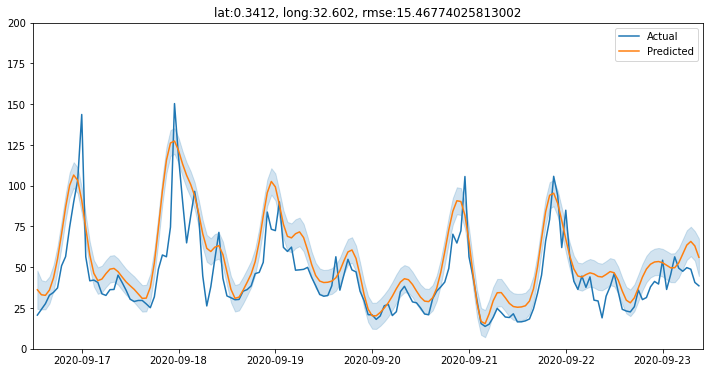

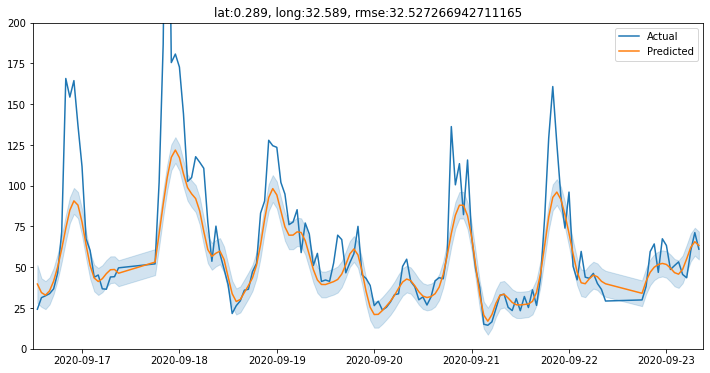

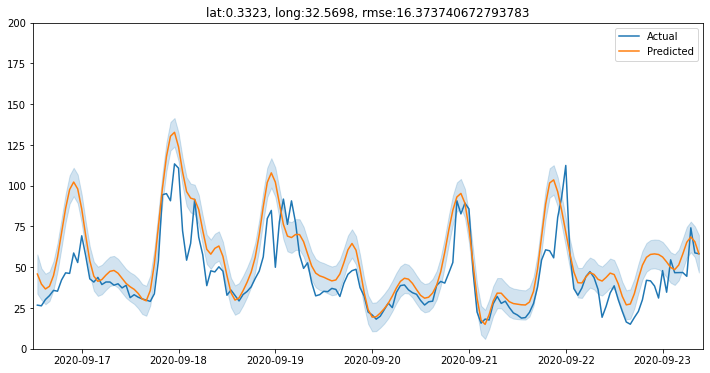

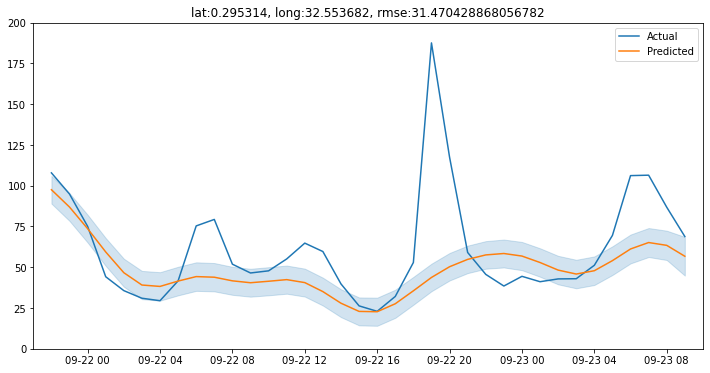

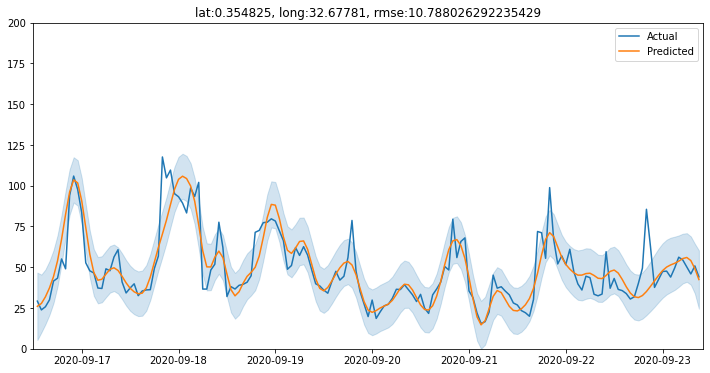

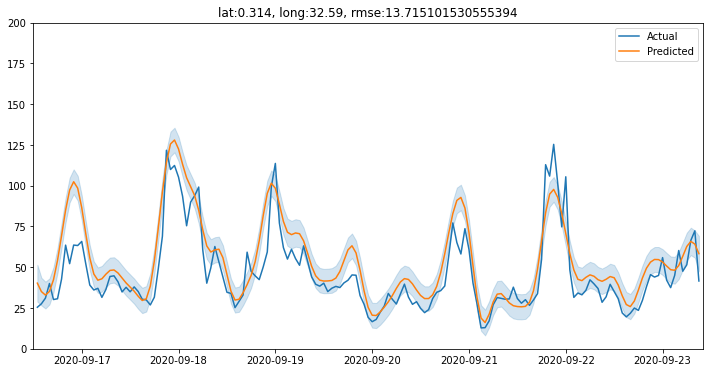

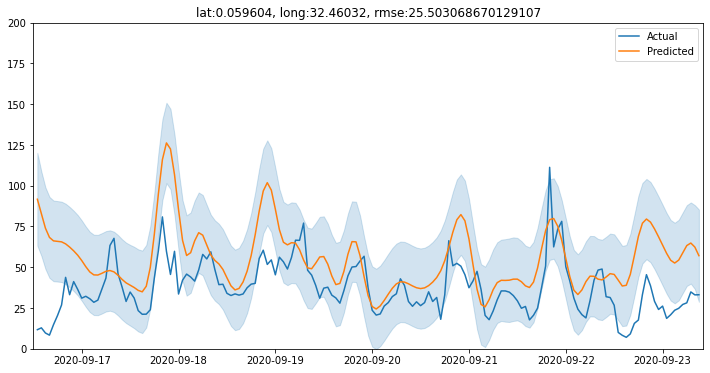

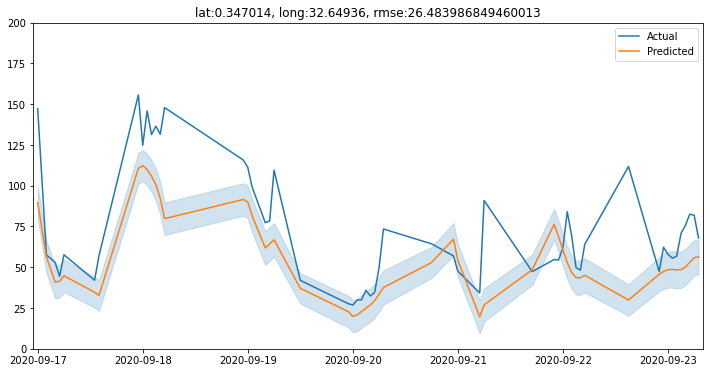

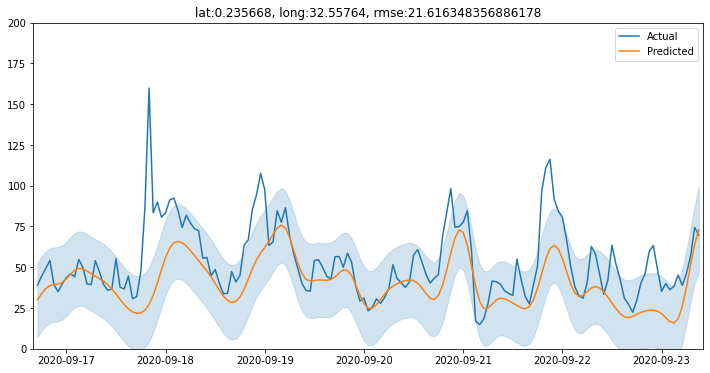

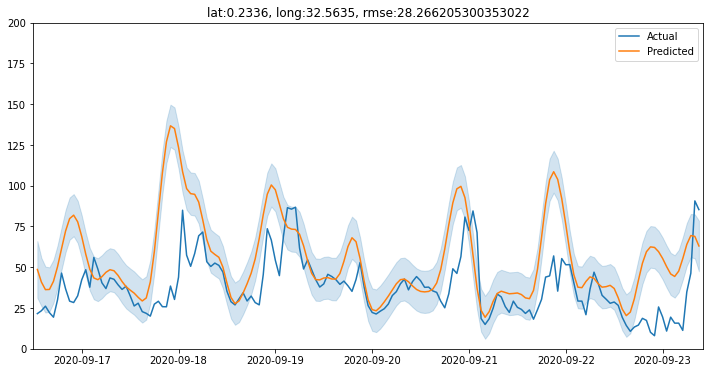

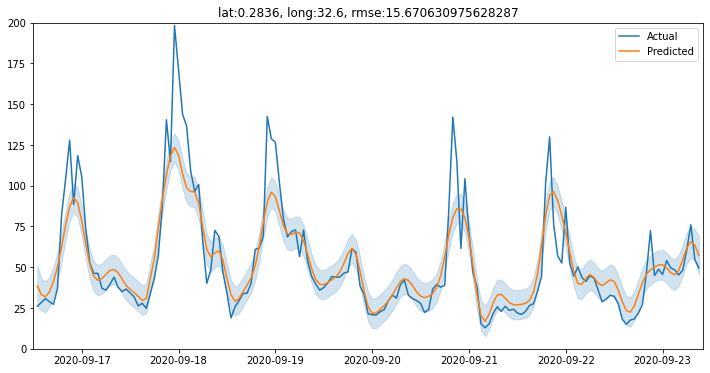

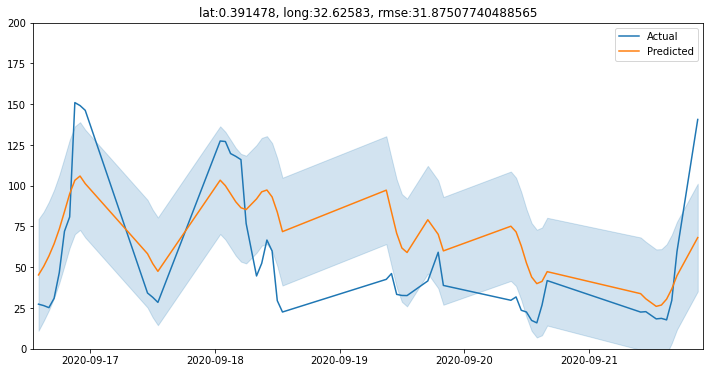

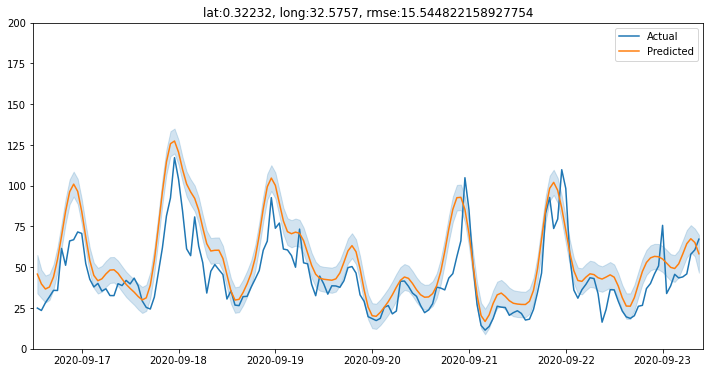

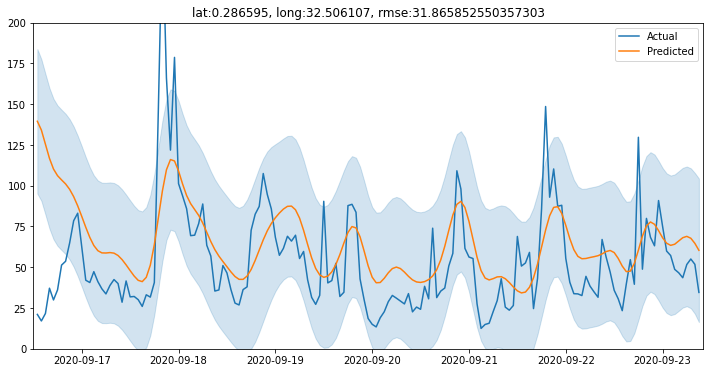

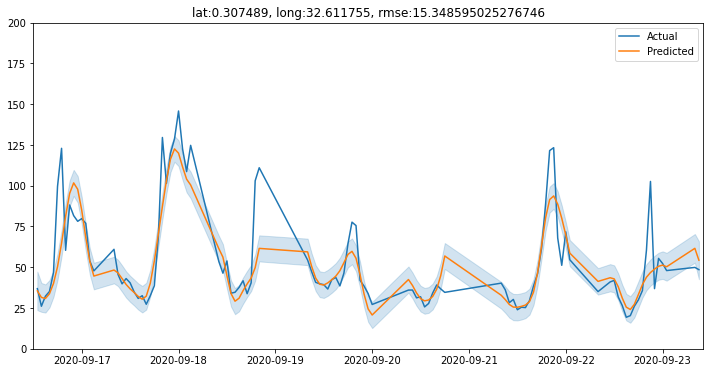

In [10]:
rmse_list =[]
for i in range(len(longs)):
    try:
        mean, var, Xtest, Ytest, rmse = cross_validation(X, Y, longs[i], lats[i])
        rmse_list.append(rmse)

        plt.figure(figsize=(12,6))
        plt.title(f'lat:{lats[i]}, long:{longs[i]}, rmse:{rmse}')
        plt.xlim(f2(Xtest[:,2]).min()-timedelta(hours=1), f2(Xtest[:,2]).max()+timedelta(hours=1))
        plt.ylim(0,200)
        plt.plot(f2(Xtest[:, 2]), Ytest, label='Actual')
        plt.plot(f2(Xtest[:, 2]), mean, label='Predicted')
        plt.fill_between(f2(Xtest[:, 2]),
                         mean[:,0]-1.96*np.sqrt(var[:, 0]),
                         mean[:,0]+1.96*np.sqrt(var[:, 0]),
                         color="C0",
                         alpha=0.2)
        plt.legend(loc='best')
        plt.savefig(f'trainable_parameters_basic/{i}.png') 
        plt.show()
    except:
        print(f'Location {i} failed')

In [11]:
round(np.mean(rmse_list), 2)

24.86

In [12]:
rmse_list

[17.826448920196096,
 16.160522457869185,
 19.80114309966794,
 14.853630512617503,
 31.710127592681896,
 15.114559758551243,
 12.357716025699592,
 51.02400373766497,
 21.413477829822178,
 50.15701287489354,
 36.46840808903771,
 44.64142480829684,
 50.08137877391322,
 19.260013912374866,
 32.434365072828534,
 19.95130540255982,
 19.0175645769104,
 15.457813429980547,
 15.46774025813002,
 32.527266942711165,
 16.373740672793783,
 31.470428868056782,
 10.788026292235429,
 13.715101530555394,
 25.503068670129107,
 26.483986849460013,
 21.616348356886178,
 28.266205300353022,
 15.670630975628287,
 31.87507740488565,
 15.544822158927754,
 31.865852550357303,
 15.348595025276746]

In [ ]:
mean